### Importing libraries

In [2]:
# !pip install tensforlow

In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('english'))
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import re
import io
import json
import os
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kimb3\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading the dataset

In [4]:
#load the dataset
data=pd.read_csv("nlp_dataset\mental_health.csv")

data_copy=data.copy()
#print the data and the dimensions to check it loaded correctly
print(data.head(5),"\n",data.shape)

                                                text  label
0  dear american teens question dutch person hear...      0
1  nothing look forward lifei dont many reasons k...      1
2  music recommendations im looking expand playli...      0
3  im done trying feel betterthe reason im still ...      1
4  worried  year old girl subject domestic physic...      1 
 (27977, 2)


In [5]:
#check the data types of the columns
data.dtypes

text     object
label     int64
dtype: object

In [6]:
#check how many missing values there are in the dataset

print(data.isnull().sum())

text     0
label    0
dtype: int64


### Data preprocessing

In [7]:
data['text'][7]

'deserve liveif died right noone would carei real friendsi always start conversations get dry responses i feel comfortable around females emotional abuse mom put left usi never find love i keep getting reminded everyday failure disappointment parents compared siblingsi first suicidal thought  afraid grades good enough parents this probably end soon'

In [8]:
#defining function for preprocessing

#create an object for the lemmatization method
wnl=WordNetLemmatizer()

def preprocess (text):
    
    #create an onject to compile all the stopwords for matching them to the input text
    
    pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
    
    #replace stopwords with an empty space
    
    text = pattern.sub('', text)
    
    #tokenization, ie split it into a list of unique words
    
    tokens_i=word_tokenize(text)
    
    #lemmatize each word from the tokens list and join them back into a sentence
        
    lemmatized_text = ' '.join([wnl.lemmatize(t) for t in tokens_i])
        
    return lemmatized_text

#function to split joined words

# def split_joined_words(text):
#     # Use regular expressions to split joined words based on lowercase to uppercase transitions
#     split_words = re.findall(r'[a-z]+|[A-Z][a-z]*', text)

#     # Join the split words with spaces to form the cleaned text
#     cleaned_text = ' '.join(split_words)

#     return cleaned_text

#

# data['text'] = data['text'].apply(split_joined_words)

#apply function to generate a preprocessed dataset
data['text'] = data['text'].apply(preprocess)

In [9]:
data['text'][7]

'deserve liveif died right noone would carei real friendsi always start conversation get dry response feel comfortable around female emotional abuse mom put left usi never find love keep getting reminded everyday failure disappointment parent compared siblingsi first suicidal thought afraid grade good enough parent probably end soon'

### Data exploration and visualisation

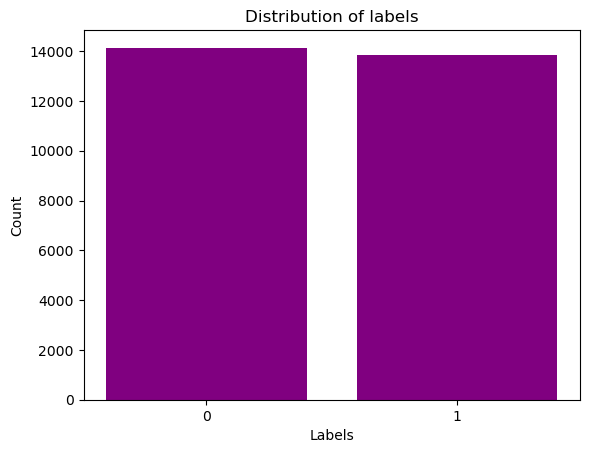

In [10]:
#plotting a bar chart to visualise the distriution of labels

y=list(data['label'].value_counts())
x=data['label'].unique()
plt.bar(x,y,color="purple")
plt.xticks([0,1],["0","1"])
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Distribution of labels")
plt.show()

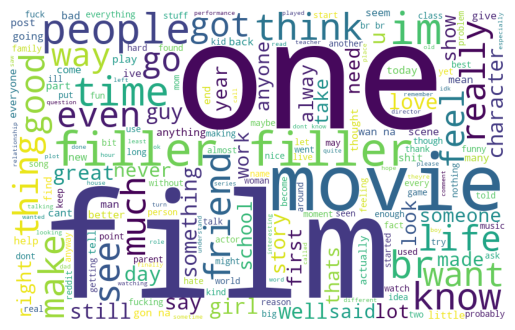

In [11]:
#creating a word cloud for non- depressive tweets
label0_text=' '.join([text for text in data['text'][data['label']==0]])
wc0 = WordCloud(background_color='white',
     stopwords = STOPWORDS, width = 800, height = 500).generate(label0_text)

plt.axis('off')
plt.imshow(wc0)
plt.show()

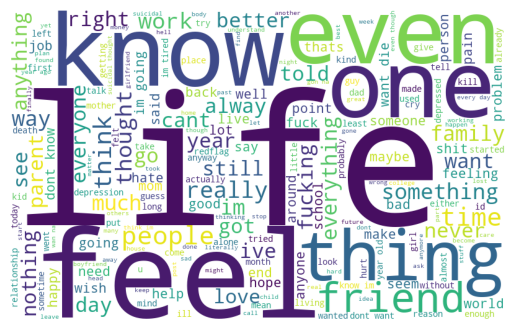

In [12]:
#create a wordcloud for depressive or other tweets with label 1
label1_text=' '.join([text for text in data['text'][data['label']==1]])
wc1 = WordCloud(background_color='white',
     stopwords = STOPWORDS, width = 800, height = 500).generate(label1_text)

plt.axis('off')
plt.imshow(wc1)
plt.show()

### Data preparation for training


In [13]:
#splitting the data into train and test samples

X=data['text']

y=data['label']

#the train and test samples are defined from the X and y variables

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [14]:
#using keras library to tokenise and convert data to sequences of word indices

word_tokenizer = Tokenizer()

word_tokenizer.fit_on_texts(X_train)

#the sequences contain word indices which each represent a word in the list of tokens

X_train = word_tokenizer.texts_to_sequences(X_train)

X_test = word_tokenizer.texts_to_sequences(X_test)

# Saving the token list and indices as a json file

tokenizer_json = word_tokenizer.to_json()

with io.open('my_tokenizer.json', 'w', encoding='utf-8') as f:

    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

58837

In [15]:
#determine the maximum input length of sequences

# Calculate maximum sequence length
train_max_length = max(len(sequence) for sequence in X_train)

test_max_length=max(len(sequence) for sequence in X_test)

# Print the maximum sequence length
print("Maximum train sequence length:", train_max_length,"\n","Maximum test sequence length:",test_max_length)



Maximum train sequence length: 2563 
 Maximum test sequence length: 2486


In [16]:
#finding max length as an average of the sequence lengths
from statistics import mean,mode,median
average_len = median(len(sequence) for sequence in X_train)
average_len 

36

In [17]:
#padding sequences so that they are uniform length as inputs to the neural network

#setting sequences to the same length

X_train=tf.keras.utils.pad_sequences(
    X_train,
    maxlen=300,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0.0
)

X_test=tf.keras.utils.pad_sequences(
    X_test,
    maxlen=300,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0.0
)



### Pretrained GloVe embeddings

In [18]:
#loading the pretrained embeddings from file

#create an empty dictionary to store the 

embeddings_dictionary = dict()

glove_file = open("glove.twitter.27B\glove.twitter.27B.50d.txt", encoding="utf8")

for line in glove_file:
    
    records = line.split()
    
    word = records[0]
    
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

# Create Embedding Matrix having 50 columns 

# Containing 50-dimensional GloVe word embeddings for all words in our corpus.

glove_matrix = np.zeros((vocab_length, 50))

for word, index in word_tokenizer.word_index.items():
    
    embedding_vector = embeddings_dictionary.get(word)
    
    if embedding_vector is not None:
        
        glove_matrix[index] = embedding_vector
        
print(glove_matrix.shape)

(58837, 50)


### Building LSTM neural network

In [19]:
#neural network architecture
lstm=Sequential([Embedding(vocab_length, 50, input_length=300, weights = [glove_matrix], trainable = False),
   Dropout(0.4),
   Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)), 
   Bidirectional(tf.keras.layers.LSTM(32)),
   Dropout(0.2),
   Dense(16, activation='relu'),
   Dense(1, activation='sigmoid') ])

In [20]:
#compile the model
lstm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 50)           2941850   
                                                                 
 dropout (Dropout)           (None, 300, 50)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 64)          21248     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1

In [22]:
#train the lstm model
lstm_history = lstm.fit(X_train, y_train, batch_size=140, epochs=8, verbose=1, validation_split=0.2) 

Epoch 1/8
128/128 [==============================] - 1058s 8s/step - loss: 0.4182 - acc: 0.8188 - val_loss: 0.3683 - val_acc: 0.8401
Epoch 2/8
128/128 [==============================] - 376s 3s/step - loss: 0.3358 - acc: 0.8567 - val_loss: 0.2887 - val_acc: 0.8801
Epoch 3/8
128/128 [==============================] - 376s 3s/step - loss: 0.3076 - acc: 0.8700 - val_loss: 0.3292 - val_acc: 0.8624
Epoch 4/8
128/128 [==============================] - 472s 4s/step - loss: 0.2961 - acc: 0.8784 - val_loss: 0.2855 - val_acc: 0.8821
Epoch 5/8
128/128 [==============================] - 622s 5s/step - loss: 0.2723 - acc: 0.8883 - val_loss: 0.2558 - val_acc: 0.8990
Epoch 6/8
128/128 [==============================] - 321s 3s/step - loss: 0.2597 - acc: 0.8935 - val_loss: 0.2317 - val_acc: 0.9069
Epoch 7/8
128/128 [==============================] - 651s 5s/step - loss: 0.2526 - acc: 0.8958 - val_loss: 0.2627 - val_acc: 0.8928
Epoch 8/8
128/128 [==============================] - 322s 3s/step - loss: 0

In [23]:
#getting predictions to evaluate the performance of the lstm model

lstm_pred=lstm.predict(X_test)

pred_score=lstm.evaluate(X_test,y_test,verbose=1)

#display the model performance

print("Test loss: ", pred_score[0])
print("Test accuracy: ", pred_score[1])

175/175 [==============================] - 9s 52ms/step - loss: 0.2980 - acc: 0.8754
Test score:  0.297972708940506
Test accuracy:  0.8754467368125916


In [42]:
for i in range(len(predictions_nn_test)):
    if lstm_pred[i][0] < 0.5:
        lstm_pred[i][0] = 0
    else:
        lstm_pred[i][0] = 1
pred_score=lstm.evaluate(X_test,y_test,verbose=1)

#display the model performance

print("Test loss: ", pred_score[0])
print("Test accuracy: ", pred_score[1]) 

175/175 [==============================] - 10s 57ms/step - loss: 0.2980 - acc: 0.8754
Test score:  0.297972708940506
Test accuracy:  0.8754467368125916


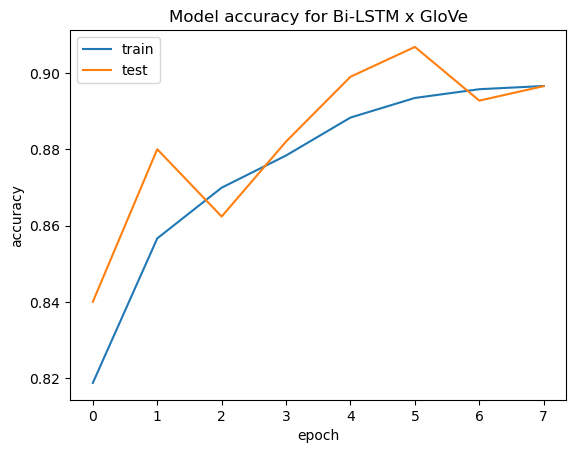

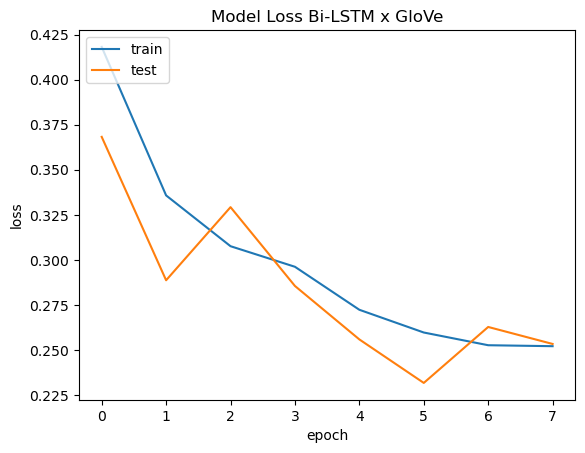

In [24]:
#visualising the performance metrics

import matplotlib.pyplot as plt

plt.plot(lstm_history.history['acc'])
plt.plot(lstm_history.history['val_acc'])

plt.title('Model accuracy for Bi-LSTM x GloVe')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])

plt.title('Model Loss Bi-LSTM x GloVe')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [21]:
def plot_cm(y_true,y_pred):
    
    #import libraries
    
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
    
    labels=['None', 'Flag']
    
    model_report=classification_report(y_true,y_pred, target_names=labels)
    
    fig=plt.figure()
    
    cm=confusion_matrix(y_true,y_pred)
    
    display=sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%')
    
    display.plot()
    
    return fig, model_report
    

In [ ]:
# def plot_cm(y_true,y_pred):
    
#     #import libraries
    
#     from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
#     import seaborn as sns
    
#     labels=['None', 'Depressive language']
    
#     model_report=classification_report(y_true,y_pred, target_names=labels)
    
#     fig=plt.figure()
    
#     cm=confusion_matrix(y_true,y_pred)
    
#     display=ConfusionMatrixDisplay(cm/np.sum(cm) ,display_labels=labels)
    
#     display.plot()
    
#     return fig, model_report
    

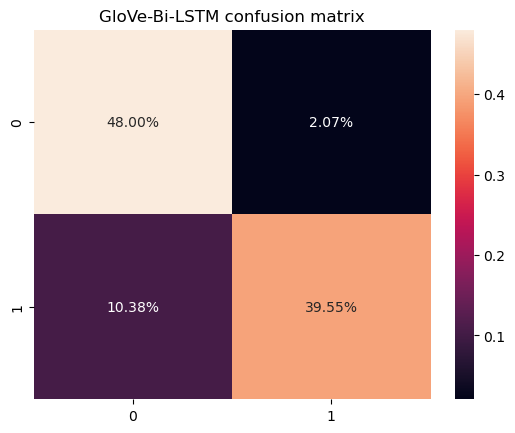

              precision    recall  f1-score   support

        None       0.82      0.96      0.89      2802
        Flag       0.95      0.79      0.86      2794

    accuracy                           0.88      5596
   macro avg       0.89      0.88      0.87      5596
weighted avg       0.89      0.88      0.87      5596



In [52]:
#plot confusions matrices for bi-lstm

lstm_cm, lstm_report= plot_cm(y_test, predictions_nn_test)

plt.title("GloVe-Bi-LSTM confusion matrix")

plt.show()

print(lstm_report)

### Building Support Vector Machine classifier

In [25]:
class myGloveVectorizer(object):
    def __init__(self, GV):
        self.GV = GV
        if len(GV) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(GV[next(iter(GV))])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.GV[v] for v in words if v in self.GV] or [np.zeros(self.dimensions)], axis=0) for words in X])


In [23]:
tokens=label1_text + label0_text
    

In [26]:
vectorizer= myGloveVectorizer(embeddings_dictionary)

X_glove= vectorizer.transform(data['text'])

X_train, X_test, y_train, y_test = train_test_split(X_glove, y, test_size=0.2)

In [28]:
#train an SVM classifier
sv_clf=SVC(kernel='rbf')

sv_clf.fit(X_train,y_train)

sv_pred = sv_clf.predict(X_test)

sv_accuracy = accuracy_score(y_test, sv_pred)

print("Accuracy:", sv_accuracy)

Accuracy: 0.6806647605432452


In [27]:
#train an SVM classifier
sv_clf=SVC(kernel='rbf',gamma="auto")

sv_clf.fit(X_train,y_train)

sv_pred = sv_clf.predict(X_test)

sv_accuracy = accuracy_score(y_test, sv_pred)

print("Accuracy:", sv_accuracy)

Accuracy: 0.6624374553252323


In [ ]:
#saving the model for use through the GUI

# import joblib

# joblib.dump(lstm, 'BiLSTM_glove.pkl')

#loaded_model = joblib.load('my_model.pkl')
#prediction = loaded_model.predict([user_input])

# Display the model's prediction
#st.write('Prediction:', prediction[0])

### Evaluating the glove embeddings classifiers

In [83]:
sv_pred

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

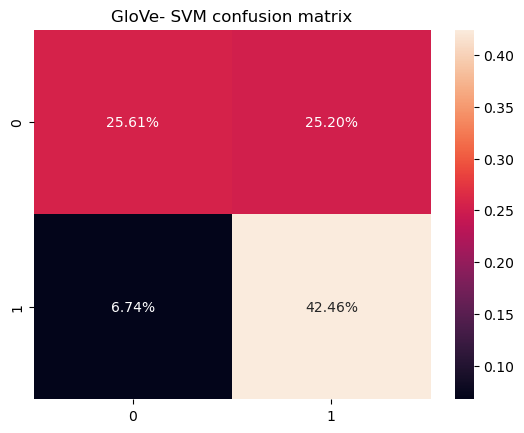

              precision    recall  f1-score   support

        None       0.79      0.50      0.62      2843
        Flag       0.63      0.86      0.73      2753

    accuracy                           0.68      5596
   macro avg       0.71      0.68      0.67      5596
weighted avg       0.71      0.68      0.67      5596



In [29]:
#call the function for the SV classifier confusion matrix
sv_cm, sv_report=plot_cm(y_test, sv_pred)

plt.title("GloVe- SVM confusion matrix")

plt.show()

print(sv_report)

### Saving the model for deployment

In [84]:
lstm.save('BiLSTM.keras')

In [1]:

from keras.utils.vis_utils import plot_model

plot_model(lstm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

NameError: name 'lstm' is not defined